In [1]:
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
from HPO.utils.model import NetworkMain
from HPO.utils.DARTS_utils import config_space_2_DARTS
from HPO.utils.FCN import FCN 
import pandas as pd
import torch
from HPO.data.teps_datasets import Train_TEPS , Test_TEPS
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
import HPO.utils.augmentation as aug
from HPO.utils.train_utils import collate_fn_padd
from HPO.utils.train import train_model, auto_train_model
from HPO.utils.weight_freezing import freeze_FCN, freeze_resnet
from HPO.utils.ResNet1d import resnet18
from HPO.utils.files import save_obj
from queue import Empty
from sklearn.model_selection import StratifiedKFold as KFold
from collections import namedtuple
from HPO.utils.worker_score import Evaluator 
from HPO.utils.worker_utils import LivePlot
import seaborn as sns

In [4]:
hpo = {'channels': 128, 'lr': 0.0250170869707739693, 'p': 0.0, 'epochs': 30, 'layers': 3}
hyperparameter = {'normal_index_0_0': 0, 'normal_index_0_1': 1, 'normal_index_1_0': 2, 'normal_index_1_1': 1, 'normal_index_2_0': 3, 'normal_index_2_1': 2, 
                  'normal_index_3_0': 2, 'normal_index_3_1': 4, 'normal_node_0_0': 'dil_conv_3x3', 'normal_node_0_1': 'none', 'normal_node_1_0': 'sep_conv_5x5', 
                  'normal_node_1_1': 'max_pool_3x3', 'normal_node_2_0': 'avg_pool_3x3', 'normal_node_2_1': 'sep_conv_7x7', 'normal_node_3_0': 'skip_connect', 
                  'normal_node_3_1': 'sep_conv_7x7', 'reduction_index_0_0': 0, 'reduction_index_0_1': 0, 'reduction_index_1_0': 1, 'reduction_index_1_1': 1, 
                  'reduction_index_2_0': 1, 'reduction_index_2_1': 3, 'reduction_index_3_0': 2, 'reduction_index_3_1': 2, 'reduction_node_0_0': 'none', 
                  'reduction_node_0_1': 'skip_connect', 'reduction_node_1_0': 'sep_conv_7x7', 'reduction_node_1_1': 'sep_conv_5x5', 'reduction_node_2_0': 'dil_conv_5x5', 
                  'reduction_node_2_1': 'skip_connect', 'reduction_node_3_0': 'skip_connect', 'reduction_node_3_1': 'sep_conv_5x5'    }

hyperparameter.update(hpo)
gen = config_space_2_DARTS(hyperparameter,reduction = True)
model = NetworkMain(52,hyperparameter["channels"],num_classes= 21 , 
                  layers = hyperparameter["layers"], auxiliary = False,drop_prob = hyperparameter["p"], genotype = gen, binary = False)

model = model.cpu()

In [6]:
instances = []
for run in range(20):
    for epoch in range(50):
        if os.path.exists("/home/cmackinnon/scripts/HPO/SWA/run-{}-checkpoint-{}".format(run,epoch)):
            instances.append(torch.load("/home/cmackinnon/scripts/HPO/SWA/run-{}-checkpoint-{}".format(run,epoch),map_location = torch.device('cpu'))) 
    print("loading [{}/30]".format(run))

loading [0/30]
loading [1/30]
loading [2/30]
loading [3/30]
loading [4/30]
loading [5/30]
loading [6/30]
loading [7/30]
loading [8/30]
loading [9/30]
loading [10/30]
loading [11/30]
loading [12/30]
loading [13/30]
loading [14/30]
loading [15/30]
loading [16/30]
loading [17/30]
loading [18/30]
loading [19/30]


In [13]:
def convert_space(instances):
    res = []
    mapping = {}
    for inst in instances:
        weights = []
        for i in inst:
            if len(inst[i].shape) > 0:
                mapping[i] = inst[i].shape
                weights.append(inst[i].reshape(1,-1).cpu())
            #else:
            #    mapping[i] = []
            
        res.append(torch.cat(weights,axis = 1))
    space = torch.cat(res,axis = 0)
    return space, mapping

def reverse_space(linear_space, mapping):
    weights = {}
    index = 0
    for key in mapping:
        shape = mapping[key]
        length = np.prod(shape)
        segment = linear_space[index : index + length]
        weights[key] = segment.reshape(shape)
        index += length
    return weights

In [8]:
len(instances)

In [10]:
a = instances[0]
a.element_size() * a.nelement()

AttributeError: 'collections.OrderedDict' object has no attribute 'element_size'

In [14]:
space, mapping = convert_space(instances)
print("Shape of space: {}".format(space.shape))

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 4092949 but got size 4062229 for tensor number 54 in the list.

In [12]:
a = space
a.element_size() * a.nelement()

818589800

In [ ]:
from HPO.utils.worker_score import Evaluator 
from imp import reload
import HPO
reload(HPO.utils.worker_score)

In [ ]:
Evaluator(batch_size, n_classes,testloader =  testloader)

In [ ]:
for i in range(30):
    w_linear = space[i,:]
    w = reverse_space(w_linear,mapping)
    model.load_state_dict(w)
    cuda_device = 1
    binary = False
    THRESHOLD = 0.4
    batch_size = 100
    model.eval()
    dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = True,
                      batch_size=batch_size,drop_last = False)

    n_classes = dataset_test.get_n_classes()
    evaluator = Evaluator(batch_size, n_classes,device = cuda_device , testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    total = evaluator.T()
    acc  =  evaluator.T_ACC()
    recall = evaluator.TPR(1)
    recall_total = evaluator.P(1)
    print("Checkpoint: {}".format(i))
    print("Accuracy: ", "%.4f" % ((acc)*100), "%")
    print("Recall: ", "%.4f" % ((recall)*100), "%")

    

In [ ]:
acc_list = []
recall_list = []
for i in range(900):
    w_linear = space[i,:]
    w = reverse_space(w_linear,mapping)
    model.load_state_dict(w)
    cuda_device = 0
    binary = True
    THRESHOLD = 0.4
    batch_size = 500
    model.eval()
    dataset_test = Test_TEPS(binary = True,samples_per_class = 500, one_hot = False)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = True,
                      batch_size=batch_size,drop_last = False)

    n_classes = dataset_test.get_n_classes()
    evaluator = Evaluator(batch_size, n_classes,cuda_device,testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    total = evaluator.T()
    acc  =  evaluator.T_ACC()
    recall = evaluator.TPR(1)
    recall_total = evaluator.P(1)
    print("Checkpoint: {}".format(i))
    print("Accuracy: ", "%.4f" % ((acc)*100), "%")
    print("Recall: ", "%.4f" % ((recall)*100), "%")
    acc_list.append(acc)
    recall_list.append(recall)
    

In [148]:
space, mapping = convert_space(instances)
print("Shape of space: {}".format(space.shape))

In [151]:
from scipy.stats import multivariate_normal

In [342]:
space.T.shape

torch.Size([279297, 900])

In [164]:

for i in range(30):
    mean = torch.mean(space[(30*i)+20:30+(30*i),:],dim = 0)
    cov = torch.cov(space[(30 * i)  + 20 : 30 + (30 * i),:].T)
    dist = np.multivariate_normal(mean.cpu().numpy(),cov.cpu().numpy())
    print(dist.sample())

RuntimeError: CUDA out of memory. Tried to allocate 290.60 GiB (GPU 0; 11.91 GiB total capacity; 6.15 GiB already allocated; 4.48 GiB free; 6.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [93]:
SWA_acc_list = []
SWA_recall_list = []
probs = []
dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False)
##Loop within run:
for i in range(20):
    w_linear = torch.mean(space[(50*i)+20:49+(50*i),:],dim = 0)
    w = reverse_space(w_linear,mapping)
    model.load_state_dict(w)
    model = model.cuda(device = 1)
    cuda_device = 1
    binary = False
    THRESHOLD = 0.4
    batch_size = 500
    model.eval()
    #dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = False,
                      batch_size=batch_size,drop_last = False)

    n_classes = dataset_test.get_n_classes()
    evaluator = Evaluator(batch_size, n_classes,cuda_device = cuda_device,testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    probs.append(evaluator.model_prob)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    total = evaluator.T()
    acc  =  evaluator.T_ACC()
    recall = evaluator.TPR(1)
    recall_total = evaluator.P(1)
    print("Accuracy: ", "%.4f" % ((acc)*100), "%")
    print("Recall: ", "%.4f" % ((recall)*100), "%")
    SWA_acc_list.append(acc)
    SWA_recall_list.append(recall)
labels = dataset_test.get_labels()

[[472.   0.   0.  27.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [463.   0.   0.  36.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 500.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  

In [99]:
preds = np.mean(probs,axis = 0)

In [100]:
probs[0][0]

array([ -4.9917984 ,  77.74919891,   1.5153681 ,  -3.93500972,
       -10.83387089, -34.20457458, -20.36344719,  29.14163399,
         7.97941875,   3.95770526,   6.7055335 ,  -1.48339105,
        -7.7352953 ,   7.54272795, -32.33239365,  -6.79570293,
       -30.52562141, -19.63397026, -11.40461731, -13.45160389,
       -35.11954117])

In [101]:
np.argmax(probs[0],axis = 1)

array([ 1,  9, 12, ...,  5, 20,  5])

In [106]:
out =np.argmax(preds, axis = 1)
labels

tensor([ 1.,  9., 12.,  ...,  5., 20.,  5.])

In [112]:

with np.printoptions(linewidth = (10*21+20),precision=4, suppress=True):
            print(confusion_matrix(out,labels))
evaluator.T_ACC(),evaluator.TPR(1)

[[  7   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [492   0   0 497   0   0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 500   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  

(0.9439047619047619, 1.0)

In [310]:
acc_list = []
recall_list = []
probs_all = []
for i in range(900):
    w_linear = space[i,:]
    w = reverse_space(w_linear,mapping)
    model.load_state_dict(w)
    cuda_device = 0
    binary = True
    THRESHOLD = 0.4
    batch_size = 500
    model.eval()
    dataset_test = Test_TEPS(binary = True,samples_per_class = 500, one_hot = False)
    testloader = torch.utils.data.DataLoader(
                      dataset_test,collate_fn = collate_fn_padd,shuffle = False,
                      batch_size=batch_size,drop_last = False)

    n_classes = dataset_test.get_n_classes()
    evaluator = Evaluator(batch_size, n_classes,cuda_device,testloader = testloader) 
    evaluator.forward_pass(model, testloader,binary)
    probs_all.append(evaluator.model_prob)
    evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
    total = evaluator.T()
    acc  =  evaluator.T_ACC()
    recall = evaluator.TPR(1)
    recall_total = evaluator.P(1)
    print("Checkpoint: {}".format(i))
    print("Accuracy: ", "%.4f" % ((acc)*100), "%")
    print("Recall: ", "%.4f" % ((recall)*100), "%")
    acc_list.append(acc)
    recall_list.append(recall)

[[  0. 500.]
 [  0. 500.]]
Checkpoint: 0
Accuracy:  50.0000 %
Recall:  100.0000 %
[[  0. 500.]
 [  0. 500.]]
Checkpoint: 1
Accuracy:  50.0000 %
Recall:  100.0000 %
[[  4. 496.]
 [  2. 498.]]
Checkpoint: 2
Accuracy:  50.2000 %
Recall:  99.6000 %
[[  0. 500.]
 [  0. 500.]]
Checkpoint: 3
Accuracy:  50.0000 %
Recall:  100.0000 %
[[  0. 500.]
 [  0. 500.]]
Checkpoint: 4
Accuracy:  50.0000 %
Recall:  100.0000 %
[[368. 132.]
 [116. 384.]]
Checkpoint: 5
Accuracy:  75.2000 %
Recall:  76.8000 %
[[355. 145.]
 [131. 369.]]
Checkpoint: 6
Accuracy:  72.4000 %
Recall:  73.8000 %
[[331. 169.]
 [ 94. 406.]]
Checkpoint: 7
Accuracy:  73.7000 %
Recall:  81.2000 %
[[500.   0.]
 [266. 234.]]
Checkpoint: 8
Accuracy:  73.4000 %
Recall:  46.8000 %
[[360. 140.]
 [ 80. 420.]]
Checkpoint: 9
Accuracy:  78.0000 %
Recall:  84.0000 %
[[490.  10.]
 [137. 363.]]
Checkpoint: 10
Accuracy:  85.3000 %
Recall:  72.6000 %
[[451.  49.]
 [116. 384.]]
Checkpoint: 11
Accuracy:  83.5000 %
Recall:  76.8000 %
[[ 17. 483.]
 [  3. 49

In [337]:
probs_late = []
for i in range(29):
    probs_late.extend(probs_all[(29+(i*30)),])

TypeError: list indices must be integers or slices, not tuple

In [338]:
preds_all

array([0.48901562])

In [331]:
preds_all = np.mean(probs_late,axis= 0)
out_all = np.zeros((1000,1))
out_all[np.where(preds_all > 0.4)] = 1

In [332]:
preds_all

array([0.48901562])

In [333]:
original = dataset_test.get_true_labels()

In [334]:
_, idx = np.where(out.T == labels.numpy())

In [32]:
from sklearn.metrics import confusion_matrix

In [343]:
evaluator.confusion_matrix = confusion_matrix(out,labels)
evaluator.T_ACC(),evaluator.TPR(1)


(0.967, 0.941398865784499)

In [336]:
confusion_matrix(out_all,labels)

array([[500, 499],
       [  0,   1]])

In [321]:
evaluator.confusion_matrix = confusion_matrix(out_all,labels)
evaluator.T_ACC(),evaluator.TPR(1)

(0.966, 0.9363295880149812)

In [132]:
import seaborn as sns

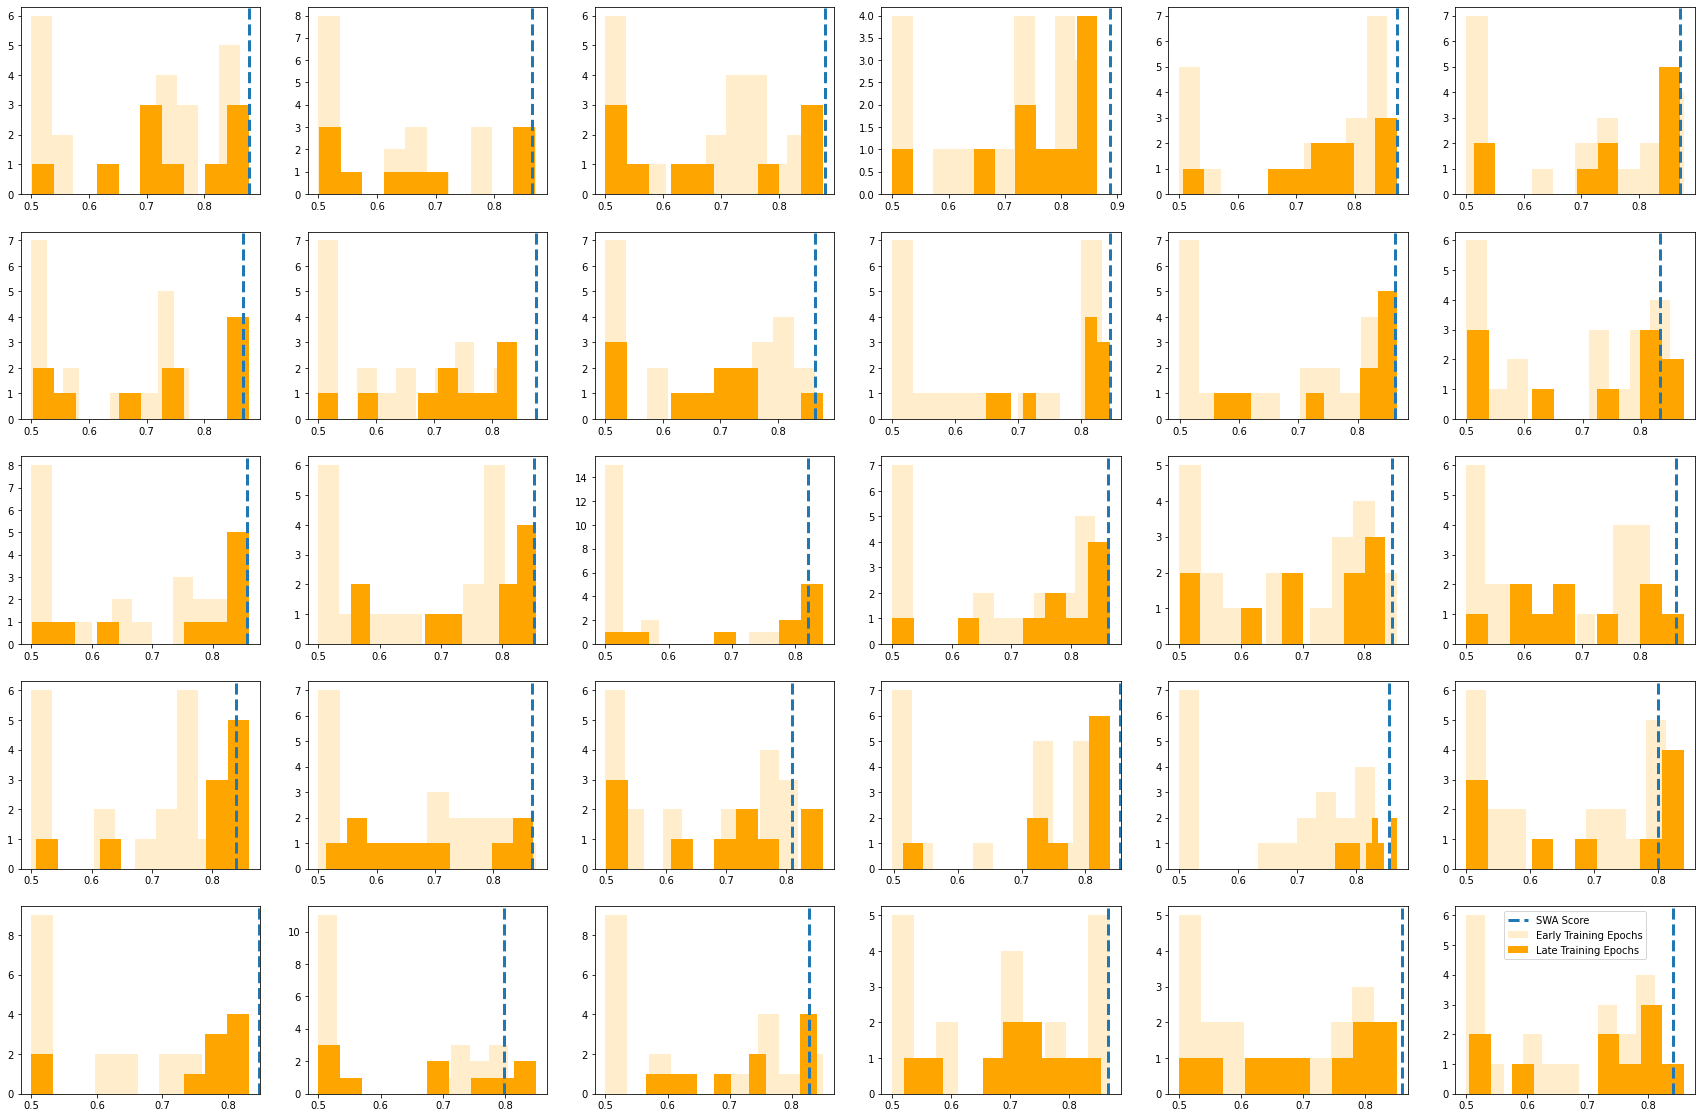

In [286]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = (30,20))
gs = gridspec.GridSpec(5, 6)

for i in range(30):
    ax = fig.add_subplot(gs[int(i/6) , i%6])
    ax.hist(acc_list[(i*30):(i*30)+20],alpha = 0.2, color = "orange",label = "Early Training Epochs")
    ax.hist(acc_list[(i*30)+20:(i*30)+30], color = "orange",label = "Late Training Epochs")
    ax.axvline(x = SWA_acc_list[i],label = "SWA Score", ls = "--",lw = 3)
plt.legend()
plt.show()


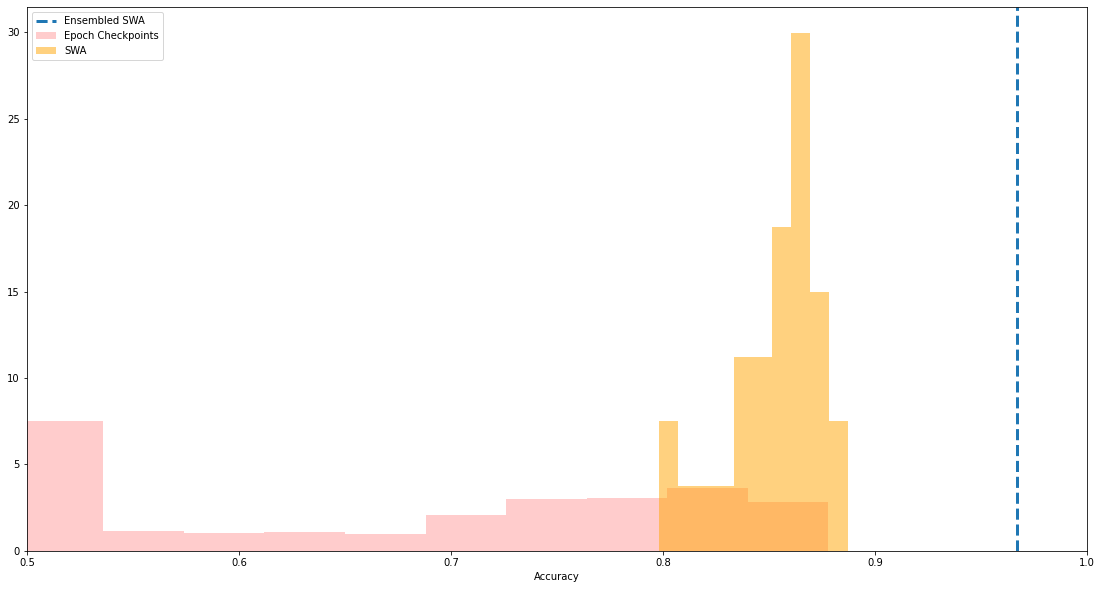

In [288]:
plt.figure(figsize = (19,10))
plt.hist(acc_list,alpha = 0.2, color = "r",density = True,label = "Epoch Checkpoints")
plt.hist(SWA_acc_list, color = "orange",density = True,alpha = 0.5,label = "SWA")
plt.axvline(x = evaluator.T_ACC(),label = "Ensembled SWA", ls = "--",lw = 3)
plt.xlim(0.5,1)
plt.legend()
plt.xlabel("Accuracy")
plt.show()

In [227]:
from sklearn.manifold import TSNE

In [228]:
data.shape

(300, 279297)

In [229]:
tsne = TSNE(n_components=2,early_exaggeration = 6, learning_rate=70,init='random',n_iter_without_progress = 1000, n_iter = 100000,  perplexity=2500,verbose = 5)

In [230]:
data_2d = tsne.fit_transform(data)

[t-SNE] Computing 299 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.153s...
[t-SNE] Computed neighbors for 300 samples in 9.396s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.377s
[t-SNE] Iteration 50: error = 10.7515144, gradient norm = 0.0000000 (50 iterations in 0.078s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 10.751514
[t-SNE] Iteration 100: error = 0.0000000, gradient norm = 0.0000000 (50 iterations in 0.082s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations: 0.000000


In [107]:
cuda_device = 0
binary = True
THRESHOLD = 0.4
batch_size = 32
model.eval()
dataset_test = Test_TEPS(binary = True,samples_per_class = 500, one_hot = False)
testloader = torch.utils.data.DataLoader(
                  dataset_test,collate_fn = collate_fn_padd,shuffle = True,
                  batch_size=batch_size,drop_last = True)

n_classes = dataset_test.get_n_classes()
evaluator = Evaluator(batch_size, n_classes,cuda_device,testloader = testloader) 
evaluator.forward_pass(model, testloader,binary)
evaluator.predictions(model_is_binary = binary , THRESHOLD = THRESHOLD)
total = evaluator.T()
acc  =  evaluator.T_ACC()
recall = evaluator.TPR(1)
recall_total = evaluator.P(1)
print("Accuracy: ", "%.4f" % ((acc)*100), "%")
print("Recall: ", "%.4f" % ((recall)*100), "%")

[[324. 172.]
 [ 65. 431.]]
Accuracy:  76.1089 %
Recall:  86.8952 %


In [105]:
model.eval()
x,y = next(iter(testloader))
print(x.shape)
p = model(x)
print(p,y)
    

torch.Size([32, 52, 800])
tensor([[14.8619],
        [ 7.3011],
        [40.2703],
        [-4.0891],
        [-0.8864],
        [-2.3867],
        [ 0.5852],
        [11.9557],
        [-0.9088],
        [-5.1408],
        [11.4973],
        [ 2.7619],
        [ 1.7542],
        [ 1.6863],
        [37.3247],
        [-2.6014],
        [35.8542],
        [-1.9523],
        [ 3.2627],
        [-3.0002],
        [-4.5330],
        [29.0857],
        [ 1.1317],
        [ 5.8625],
        [-4.8772],
        [ 9.1941],
        [-2.3424],
        [-8.0891],
        [ 5.8284],
        [-0.5457],
        [-4.2490],
        [ 0.1154]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')


In [232]:
import matplotlib.cm as cm
x = np.arange(30)
ys = [i+x+(i*x)**2 for i in range(30)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

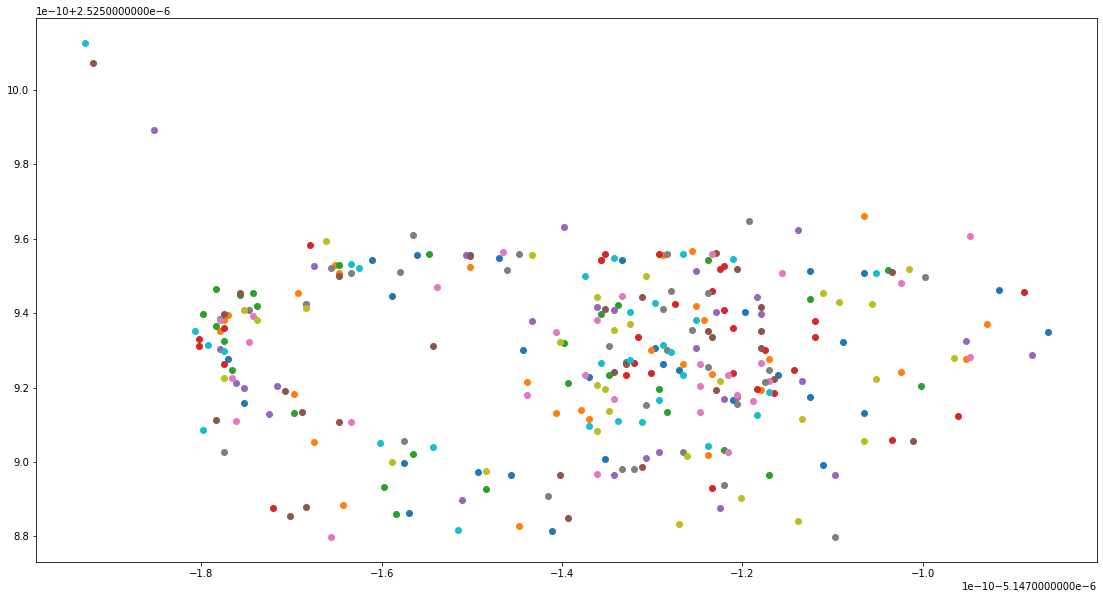

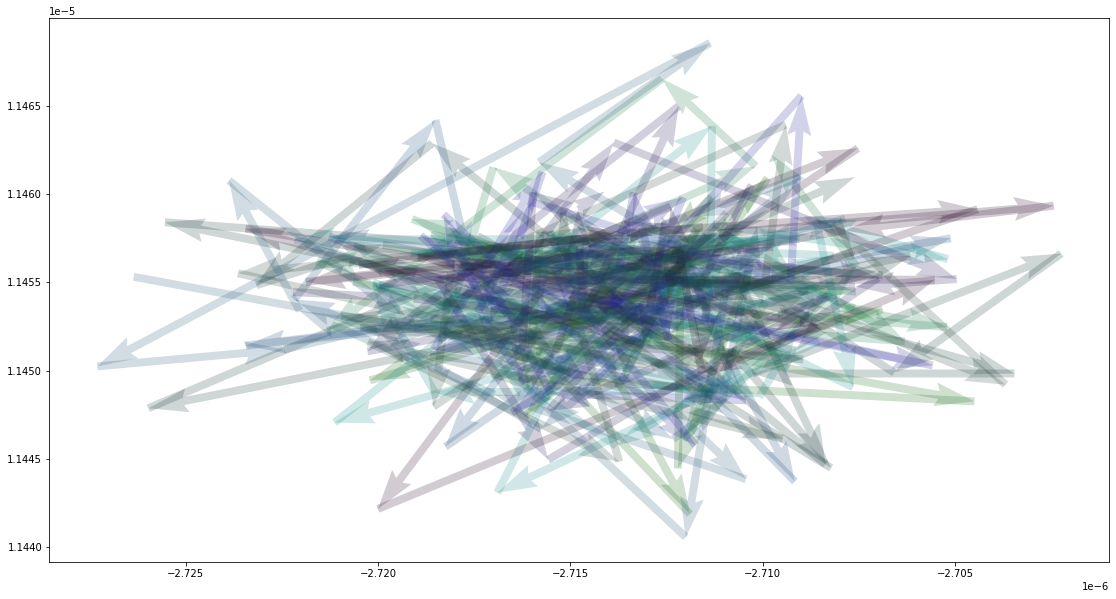

In [266]:
plt.figure(figsize = (19,10))
for i in range(30):
    x,y = data_2d[30*i:(30*i)+30,0],data_2d[30*i:(30*i)+30,1]
    c = "#{}".format(1337+i*137)

    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color = c, alpha = 0.2)
    